The current downscale scale space is a really lazy solution and throws out data.
Solution: use custom difference-of-gaussians kernel, with adaptive sigma value

idea: implement actual size of image in calculation, and have sigma with units [length], instead of unitless/[px].

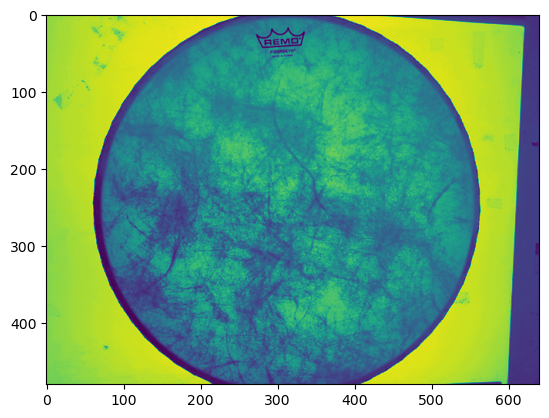

In [98]:
import cv2 as cv
import numpy as np
from skimage.color import rgb2gray
from numpy.lib.stride_tricks import sliding_window_view
import matplotlib.pyplot as plt

drum = rgb2gray(cv.imread("drumhead.jpg"))
plt.imshow(drum)

In [ ]:
# generate Derivative of Gaussian
# will automatically generate appropriate radius if none is given
def generate_dogs(sigma, kernel_radius, mode='l2'):
    diameter = np.arange(-1*kernel_radius, kernel_radius+1)
    mesh = np.meshgrid(diameter, diameter)
    gaussian_unnormalized = np.exp((-1*mesh[0] * mesh[0] - mesh[1] * mesh[1])/(sigma * sigma))
    ddx_unnormalized = gaussian_unnormalized * mesh[0]
    ddy_unnormalized = gaussian_unnormalized * mesh[1]
    norm = 0
    if mode=='l1':
        norm = np.abs(ddx_unnormalized).sum()
    else:
        norm = (ddx_unnormalized * ddx_unnormalized).sum()
    ddx, ddy = (ddx_unnormalized, ddy_unnormalized) / norm
    return ddx, ddy

In [118]:
def get_image_gradients(image : np.ndarray, sigma = -1, kernel_radius = -1, sigma_to_ydim_ratio = -1, std_cutoff=3, mode = 'l2'):
    if sigma == -1:
        if sigma_to_ydim_ratio == -1:
            sigma = 1
        else:
            sigma = image.shape[0] * sigma_to_ydim_ratio
    if kernel_radius == -1:
        kernel_radius = int(std_cutoff * sigma)
    
    padded_image = cv.copyMakeBorder(image, kernel_radius, kernel_radius, kernel_radius, kernel_radius, cv.BORDER_WRAP)
    ddx, ddy = generate_dogs(sigma, kernel_radius)
    padded_image_window = sliding_window_view(padded_image, (2 * kernel_radius + 1, 2 * kernel_radius + 1))
    ix = (padded_image_window * ddx).sum(axis=(2, 3))
    iy = (padded_image_window * ddy).sum(axis=(2, 3))
    return ix, iy

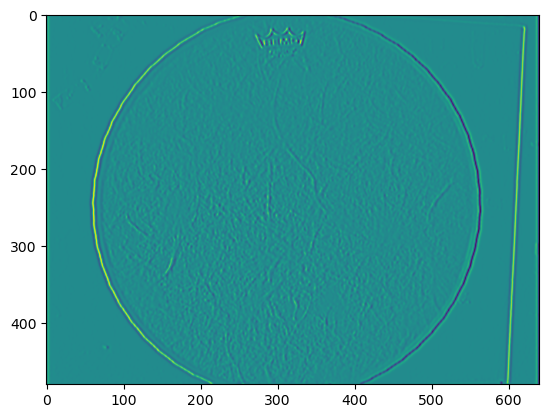

In [130]:
ix, iy = get_image_gradients(drum, sigma=3, std_cutoff=2)
# ix2, iy2 = get_image_gradients(drum, sigma=5, std_cutoff=3)
plt.imshow(ix - ix2)

In [131]:
# (ix - ix2).max()
np.abs(ix).mean()

0.03776394531396106

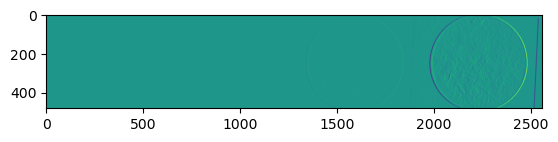

In [ ]:
ksizes = [3, 5, 7, 9]
images = [cv.Sobel(drum, cv.CV_16S, dx=1, dy=0, ksize=ksize)/(ksize * ksize) for ksize in ksizes]
image_gradients = [get_image_gradients(drum, )]
images_normalized = [image/np.abs(image).mean() for image in images]
# ix = cv.Sobel(drum, cv.CV_16S, dx=1, dy=0, ksize=9)
# iy = cv.Sobel(drum, cv.CV_16S, dx=0, dy=1, ksize=9)
big_image = cv.hconcat(images)
plt.imshow(big_image)
# magnitude = np.sqrt(ix * ix + iy * iy)
# plt.imshow(magnitude/magnitude.max())

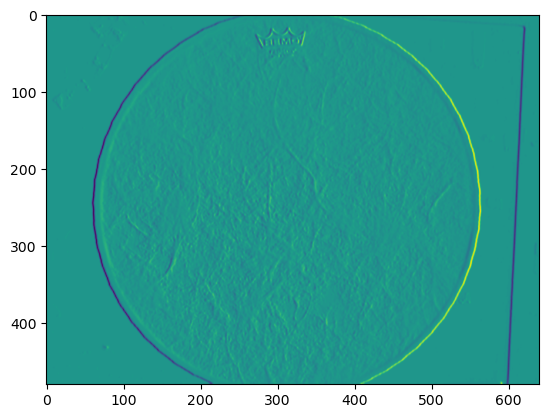

In [87]:
plt.imshow(images[1])

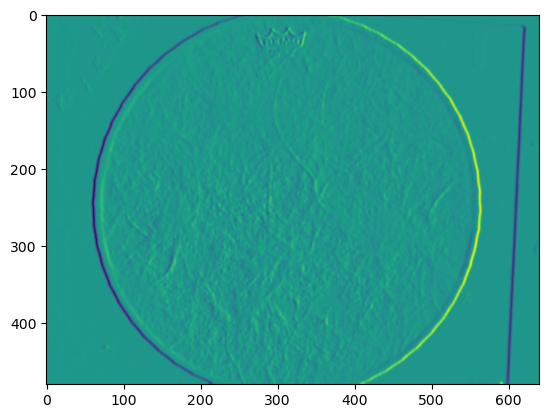

In [86]:
plt.imshow(images[3])

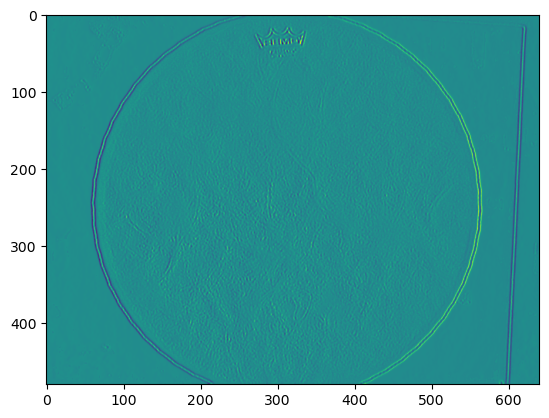

In [89]:
plt.imshow(images[3]/np.abs(images[3]).mean() - images[1]/np.abs(images[1]).mean())